This script applies K-means clustering (n=5) and visualizes the results using UMAP.

Key steps:
1. **Perform K-means clustering (n=5)**:
   - Fit a K-means model to the PCA-transformed data.
   - **Input:** `'Data/pca_model_n1000_rdm42.joblib'`, `'Data/pca_transformed_n1000_rdm42.npy'`.

2. **Visualize clusters using UMAP**:
   - Scatter plot of UMAP embeddings colored by K-means cluster labels.
   - Save UMAP embeddings and model for future analysis.
   - **Output:** `'Data/umap_embedding_diagnosis.pkl'`, `'Data/umap_model_diagnosis.joblib'`.

3. **Merge cluster labels with patient data**:
   - Merge encoded cluster labels with the diagnosis dataset.
   - Store the updated dataset with cluster information for further analysis.
   - **Input:** `'Data/alzdiag_pivot_rdm42.pkl'`.
   - **Output:** `'Data/kmeans_clusters_n5_rdm42_diagnosis.pkl'`.


In [1]:
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import umap
pd.set_option('display.max_rows', 50)
np.set_printoptions(threshold=50)
import joblib
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
import pickle
from joblib import load

# 1. Create five clusters by K-means Clustering

## Load analysis datasets

In [2]:
pca = joblib.load('Data/pca_model_n1000_rdm42.joblib')
data_pca = np.load('Data/pca_transformed_n1000_rdm42.npy')

## Kmeans Clustering (n=5) & UMAP visualization

In [3]:
# K-means Clustering(n =5)
kmeans5 = KMeans(n_clusters=5, random_state=42) 
kmeans5.fit(data_pca)
data_pca_kmeans5 = kmeans5.fit_transform(data_pca)

In [4]:
kmeans5_labels = kmeans5.labels_

In [5]:
%%time
mapper = umap.UMAP(metric='cosine', random_state=42, low_memory=True, verbose = 1)
X_embedded = mapper.fit_transform(data_pca)

/wynton/protected/home/sirota/ykatsuhara/.local/lib/python3.7/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(angular_rp_forest=True, metric='cosine', random_state=42, verbose=1)
Thu Feb 27 16:56:13 2025 Construct fuzzy simplicial set
Thu Feb 27 16:56:13 2025 Finding Nearest Neighbors
Thu Feb 27 16:56:13 2025 Building RP forest with 10 trees
Thu Feb 27 16:56:14 2025 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	 5  /  13
	 6  /  13
	Stopping threshold met -- exiting after 6 iterations
Thu Feb 27 16:56:29 2025 Finished Nearest Neighbor Search
Thu Feb 27 16:56:32 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Feb 27 16:56:59 2025 Finished embedding
CPU times: user 1min 11s, sys: 11.9 s, total: 1min 23s
Wall time: 46.3 s


In [6]:
# Save UMAP transformed data
with open('Data/umap_embedding_diagnosis.pkl', 'wb') as f:
    pickle.dump(X_embedded, f)

In [7]:
# Save the UMAP Model
joblib.dump(mapper, 'Data/umap_model_diagnosis.joblib')

Thu Feb 27 16:57:02 2025 Worst tree score: 0.41958627
Thu Feb 27 16:57:02 2025 Mean tree score: 0.43603970
Thu Feb 27 16:57:02 2025 Best tree score: 0.45258878
Thu Feb 27 16:57:05 2025 Forward diversification reduced edges from 125445 to 50204
Thu Feb 27 16:57:08 2025 Reverse diversification reduced edges from 50204 to 50204


/wynton/protected/home/sirota/ykatsuhara/.local/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Thu Feb 27 16:57:11 2025 Degree pruning reduced edges from 61722 to 61491
Thu Feb 27 16:57:11 2025 Resorting data and graph based on tree order
Thu Feb 27 16:57:11 2025 Building and compiling search function


['Data/umap_model_diagnosis.joblib']

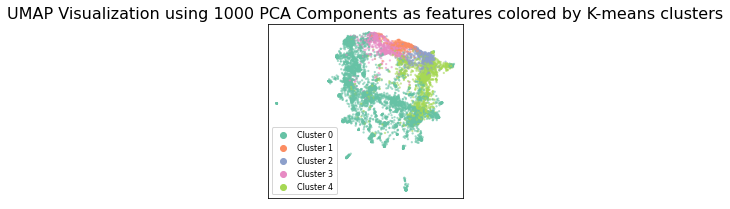

In [8]:
with sns.color_palette("Set2"):
    fig = plt.figure(figsize=(3.5, 3.2))  # Set figure size
    
    np.random.seed(1)  # Set random seed for reproducibility
    reordered_indices = np.arange(X_embedded.shape[0])  # Generate index array
    np.random.shuffle(reordered_indices)  # Shuffle indices to randomize plotting order
    
    # Create scatter plot with UMAP components colored by K-means clusters
    sns.scatterplot(x=X_embedded[reordered_indices, 0], 
                    y=X_embedded[reordered_indices, 1], 
                    hue=kmeans5.labels_[reordered_indices],
                    s=5, linewidth=0, alpha=0.6, 
                    palette="Set2")

    ax = plt.gca()  # Get current axis
    ax.set(xticks=[], yticks=[], facecolor='white')  # Remove axis ticks and set background color
    plt.title("UMAP Visualization using 1000 PCA Components as features colored by K-means clusters", fontsize=16)
    
    # Customize legend labels
    handles, labels = ax.get_legend_handles_labels()  # Retrieve legend handles and labels
    labels = [f"Cluster {label}" for label in labels]  # Prefix cluster numbers with 'Cluster'
    ax.legend(handles=handles, labels=labels, title='', loc='lower left', fontsize=8)  # Update legend


# 2. Merge the cluster information to alzdiag_pivot

In [9]:
alzdiag_pivot = pd.read_pickle('Data/alzdiag_pivot_rdm42.pkl')

In [10]:
demographic_cols = ['Age', 'Sex', 'Race', 'Death_Status','#diagnosis']

In [11]:
z = alzdiag_pivot[demographic_cols]
X = alzdiag_pivot.drop('isAD', axis=1).drop(demographic_cols, axis=1).astype('int32')

In [12]:
X['ClusterLabel'] = kmeans5_labels

In [13]:
# OneHotEncoder
encoder = OneHotEncoder(sparse=False)

# Encoding the Cluster Label
X_encoded = encoder.fit_transform(X[['ClusterLabel']])

In [14]:
# Data Frame of the encoded clusters
X_encoded_df = pd.DataFrame(X_encoded, columns=[f'Cluster_{i}' for i in range(X_encoded.shape[1])])

In [15]:
X_encoded_df.head(3)

,Cluster_0,Cluster_1,Cluster_2,Cluster_3,Cluster_4
0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0


In [16]:
# Change the index to Patient ID
X_encoded_df.index = z.index

In [17]:
# Merge the OneHot Encoded cluster info to alzdiag_pivot
alzdiag_pivot_cluster = alzdiag_pivot.join(X_encoded_df)

In [18]:
# Create the dataframe of Cluster Label
labels = pd.DataFrame(kmeans5_labels, columns=['Cluster'])

In [19]:
# Change the index to Patient ID
labels.index = z.index

In [20]:
# Merge the cluster label to alzdiag_pivot
alzdiag_pivot_cluster = alzdiag_pivot_cluster.join(labels)

In [21]:
# Save as Pickle file
with open('Data/kmeans_clusters_n5_rdm42_diagnosis.pkl', 'wb') as f:
    pickle.dump(alzdiag_pivot_cluster, f)